In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import torch

from cbx.dynamics import CBO
from cbx import plotting
from cbx.noise import anisotropic_noise
import cbx.utils.resampling as rsmp
from cbx.utils.postprocessing import CompositePostProcess, DefaultPostProcess, ReshuffleAgentBatches

# Utils

## Plotting

In [2]:
def surface_plot(f, x_range, y_range, num_points=100, cmap='bwr', x_label='x', y_label='y', z_label='z'):
    """
    Plots a surface plot for the given function f(x, y).
    
    Parameters:
        f (function): A function of two variables.
        x_range (tuple): A tuple specifying the range of x values as (x_min, x_max).
        y_range (tuple): A tuple specifying the range of y values as (y_min, y_max).
        num_points (int): The number of points in the grid for x and y.
        cmap (str): The colormap to use for the plot.
        x_label (str): The label for the X-axis.
        y_label (str): The label for the Y-axis.
        z_label (str): The label for the Z-axis.
    """
    
    # Create grid
    x = np.linspace(x_range[0], x_range[1], num_points)
    y = np.linspace(y_range[0], y_range[1], num_points)
    X, Y = np.meshgrid(x, y)
    Z = f(np.stack((X, Y), axis=-1))

    # Plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap=cmap)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_zlabel(z_label)
    plt.show()

## Evaluation

In [3]:
def mse_loss(actual: torch.tensor, target: torch.tensor) -> float:
    return torch.mean(torch.square(actual - target))

## Optimization

### Gradient Descent

In [4]:
def gradient_descent(func, init, learning_rate=0.01, n_iter=1000, tolerance=1e-6):
    """
    Perform gradient descent optimization on a function using PyTorch.

    Parameters:
    - func: Callable, the function to optimize.
    - init: torch.Tensor, initial guess.
    - learning_rate: float, step size.
    - n_iter: int, maximum number of iterations.
    - tolerance: float, threshold for convergence.

    Returns:
    - torch.Tensor, the optimal parameter value.
    - list, the history of parameter values.
    - list, the history of function values.
    """
    x = torch.tensor(init, requires_grad=True)
    optimizer = torch.optim.SGD([x], lr=learning_rate)
    history_params = [x.detach().clone()]
    history_values = [func(x).item()]

    for _ in range(n_iter):
        optimizer.zero_grad()
        y = func(x)
        y.backward()
        optimizer.step()
        history_params.append(x.detach().clone())
        history_values.append(func(x).item())

        if torch.norm(x - history_params[-2]) < tolerance:
            break

    return x.detach(), history_params, history_values

# Benchmark Functions

## Bowl-Shaped Functions (Sanity Check)

### Sphere Function
$f(x) = \sum_{i=1}^d{x_i^2}$

In [5]:
def sphere(x: torch.tensor) -> float:
    return torch.sum(torch.square(x), dim=-1)

f = lambda x: sphere(torch.tensor(x[None, :]))[-1]

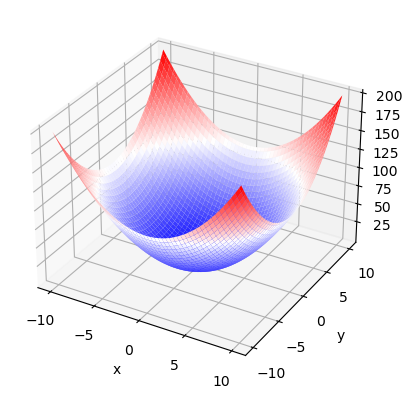

In [6]:
surface_plot(f, (-10, 10), (-10, 10))

In [7]:
kwargs = {
    'noise': 'anisotropic',
    'sigma': 0.1,
}

M = kwargs.get('M', 1)
resampling =  rsmp.resampling([rsmp.loss_update_resampling(M=M, wait_thresh=40)], M)
post_process = CompositePostProcess([
    DefaultPostProcess(),
    ReshuffleAgentBatches(),
    lambda dyn: resampling(dyn)
])

d = 2
dyn = CBO(
    f,
    d=d,
    track_args={"names": ["x", "consensus"]},
    verbosity=1,
    post_process=post_process,
    **kwargs
)
result = dyn.optimize()

....................
Starting Optimization with dynamic: CBO
....................
Time: 0.010, best current energy: [0.01626085]
Number of function evaluations: [40]
Time: 0.020, best current energy: [0.01611131]
Number of function evaluations: [60]
Time: 0.030, best current energy: [0.01610228]
Number of function evaluations: [80]
Time: 0.040, best current energy: [0.01619847]
Number of function evaluations: [100]
Time: 0.050, best current energy: [0.01606298]
Number of function evaluations: [120]
Time: 0.060, best current energy: [0.01617976]
Number of function evaluations: [140]
Time: 0.070, best current energy: [0.01607313]
Number of function evaluations: [160]
Time: 0.080, best current energy: [0.01625532]
Number of function evaluations: [180]
Time: 0.090, best current energy: [0.01618051]
Number of function evaluations: [200]
Time: 0.100, best current energy: [0.01599508]
Number of function evaluations: [220]
Time: 0.110, best current energy: [0.01667066]
Number of function evalu

Time: 4.020, best current energy: [0.01005104]
Number of function evaluations: [8060]
Time: 4.030, best current energy: [0.01002193]
Number of function evaluations: [8080]
Time: 4.040, best current energy: [0.01002413]
Number of function evaluations: [8100]
Time: 4.050, best current energy: [0.01002414]
Number of function evaluations: [8120]
Time: 4.060, best current energy: [0.01002414]
Number of function evaluations: [8140]
Time: 4.070, best current energy: [0.00999603]
Number of function evaluations: [8160]
Time: 4.080, best current energy: [0.00993758]
Number of function evaluations: [8180]
Time: 4.090, best current energy: [0.00992907]
Number of function evaluations: [8200]
Time: 4.100, best current energy: [0.00992362]
Number of function evaluations: [8220]
Time: 4.110, best current energy: [0.00992271]
Number of function evaluations: [8240]
Time: 4.120, best current energy: [0.00992374]
Number of function evaluations: [8260]
Time: 4.130, best current energy: [0.00992468]
Number 

Time: 9.670, best current energy: [0.00031207]
Number of function evaluations: [19360]
Time: 9.680, best current energy: [0.00031207]
Number of function evaluations: [19380]
Time: 9.690, best current energy: [0.00031207]
Number of function evaluations: [19400]
Time: 9.700, best current energy: [0.00031207]
Number of function evaluations: [19420]
Time: 9.710, best current energy: [0.00031207]
Number of function evaluations: [19440]
Time: 9.720, best current energy: [0.00031207]
Number of function evaluations: [19460]
Time: 9.730, best current energy: [0.00031207]
Number of function evaluations: [19480]
Time: 9.740, best current energy: [0.00031207]
Number of function evaluations: [19500]
Time: 9.750, best current energy: [0.00031207]
Number of function evaluations: [19520]
Time: 9.760, best current energy: [0.00031207]
Number of function evaluations: [19540]
Time: 9.770, best current energy: [0.00031207]
Number of function evaluations: [19560]
Time: 9.780, best current energy: [0.000312

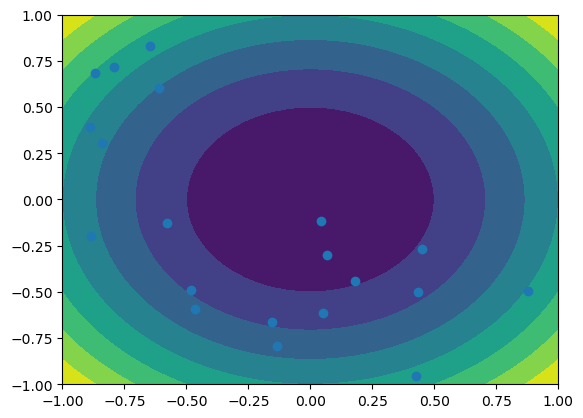

In [8]:
plotter = plotting.plot_dynamic_history(dyn, objective_args={"x_min": -1, "x_max": 1})

In [9]:
target = torch.zeros((1, d))
mse_loss(torch.tensor(result), target)

tensor(8.5105e-06, dtype=torch.float64)

In [10]:
f(result).min()

tensor(1.7021e-05, dtype=torch.float64)

### Compare to SGD

In [11]:
x = torch.normal(0, 1, size=(1, d))

best_x, history_params, history_values, = gradient_descent(sphere, x)
mse_loss(best_x, target)

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_46879/673266039.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(init, requires_grad=True)


tensor(1.1770e-09)

In [12]:
f(best_x)

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_46879/2811881927.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  f = lambda x: sphere(torch.tensor(x[None, :]))[-1]


tensor([2.3541e-09])

### Parabola with Non-Zero Minimizer
$f(x) = (x_1 - 3)^2 + (x_2 + 4)^2 + 5$

In [13]:
def non_centered_paraboloid(x: torch.tensor) -> float:
    return (4*x[..., 0] - 3)**2 + (x[..., 1] + 4)**2 + 5

f = lambda x: non_centered_paraboloid(torch.tensor(x[None, :]))[-1]

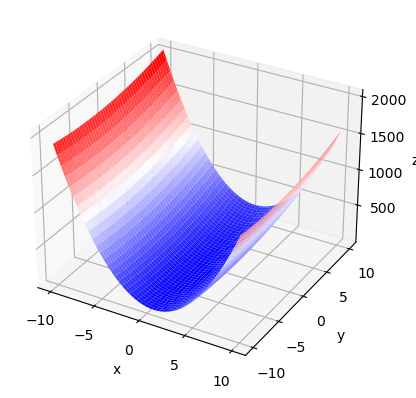

In [14]:
surface_plot(f, (-10, 10), (-10, 10))

In [15]:
# Hyperparameters
kwargs = {
    'noise': 'anisotropic',
    'sigma': 5,
}

M = kwargs.get('M', 1)
resampling =  rsmp.resampling([rsmp.loss_update_resampling(M=M, wait_thresh=40)], M)
post_process = CompositePostProcess([
    DefaultPostProcess(),
    ReshuffleAgentBatches(),
    lambda dyn: resampling(dyn)
])

d = 2
dyn = CBO(
    f,
    d=d,
    track_args={"names": ["x", "consensus"]},
    verbosity=1,
    post_process=post_process,
    **kwargs
)
result = dyn.optimize()

....................
Starting Optimization with dynamic: CBO
....................
Time: 0.010, best current energy: [16.31933222]
Number of function evaluations: [40]
Time: 0.020, best current energy: [16.16833157]
Number of function evaluations: [60]
Time: 0.030, best current energy: [16.14076314]
Number of function evaluations: [80]
Time: 0.040, best current energy: [15.5918479]
Number of function evaluations: [100]
Time: 0.050, best current energy: [15.37113413]
Number of function evaluations: [120]
Time: 0.060, best current energy: [15.16895067]
Number of function evaluations: [140]
Time: 0.070, best current energy: [15.47642984]
Number of function evaluations: [160]
Time: 0.080, best current energy: [15.22267976]
Number of function evaluations: [180]
Time: 0.090, best current energy: [15.34485564]
Number of function evaluations: [200]
Time: 0.100, best current energy: [15.23367979]
Number of function evaluations: [220]
Time: 0.110, best current energy: [15.18809761]
Number of func

Time: 2.490, best current energy: [5.00000062]
Number of function evaluations: [5000]
Time: 2.500, best current energy: [5.00000125]
Number of function evaluations: [5020]
Time: 2.510, best current energy: [5.00000147]
Number of function evaluations: [5040]
Time: 2.520, best current energy: [5.00000146]
Number of function evaluations: [5060]
Time: 2.530, best current energy: [5.00000137]
Number of function evaluations: [5080]
Time: 2.540, best current energy: [5.00000133]
Number of function evaluations: [5100]
Time: 2.550, best current energy: [5.00000134]
Number of function evaluations: [5120]
Time: 2.560, best current energy: [5.00000131]
Number of function evaluations: [5140]
Time: 2.570, best current energy: [5.00000072]
Number of function evaluations: [5160]
Time: 2.580, best current energy: [5.00000107]
Number of function evaluations: [5180]
Time: 2.590, best current energy: [5.00000146]
Number of function evaluations: [5200]
Time: 2.600, best current energy: [5.00000125]
Number 

Time: 5.500, best current energy: [5.00011786]
Number of function evaluations: [11020]
Time: 5.510, best current energy: [5.00011786]
Number of function evaluations: [11040]
Time: 5.520, best current energy: [5.00011786]
Number of function evaluations: [11060]
Time: 5.530, best current energy: [5.00011786]
Number of function evaluations: [11080]
Time: 5.540, best current energy: [5.00011786]
Number of function evaluations: [11100]
Time: 5.550, best current energy: [5.00011786]
Number of function evaluations: [11120]
Time: 5.560, best current energy: [5.00011786]
Number of function evaluations: [11140]
Time: 5.570, best current energy: [5.00011786]
Number of function evaluations: [11160]
Time: 5.580, best current energy: [5.00011786]
Number of function evaluations: [11180]
Time: 5.590, best current energy: [5.00010864]
Number of function evaluations: [11200]
Time: 5.600, best current energy: [5.0001067]
Number of function evaluations: [11220]
Time: 5.610, best current energy: [5.0001036

Time: 8.690, best current energy: [5.00476839]
Number of function evaluations: [17400]
Time: 8.700, best current energy: [5.00476839]
Number of function evaluations: [17420]
Time: 8.710, best current energy: [5.00476839]
Number of function evaluations: [17440]
Time: 8.720, best current energy: [5.00476839]
Number of function evaluations: [17460]
Time: 8.730, best current energy: [5.00476839]
Number of function evaluations: [17480]
Time: 8.740, best current energy: [5.00476839]
Number of function evaluations: [17500]
Time: 8.750, best current energy: [5.00476839]
Number of function evaluations: [17520]
Time: 8.760, best current energy: [5.00476839]
Number of function evaluations: [17540]
Time: 8.770, best current energy: [5.00281925]
Number of function evaluations: [17560]
Time: 8.780, best current energy: [5.0005335]
Number of function evaluations: [17580]
Time: 8.790, best current energy: [5.0005335]
Number of function evaluations: [17600]
Time: 8.800, best current energy: [5.0005335]

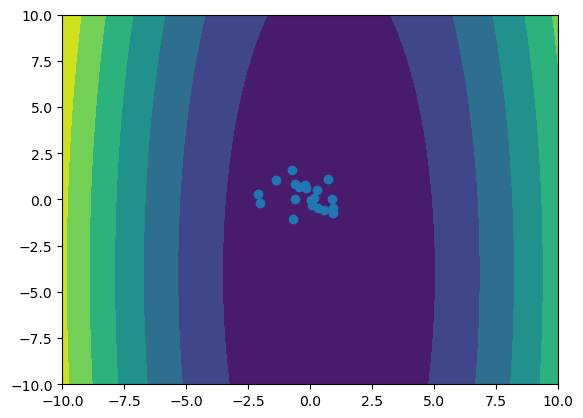

In [16]:
plotter = plotting.plot_dynamic_history(dyn, objective_args={"x_min": -10, "x_max": 10})

In [17]:
target = torch.tensor([3/4, -4])
mse_loss(torch.tensor(result), target)

tensor(3.7254e-10, dtype=torch.float64)

In [18]:
f(result)

tensor([5.0000], dtype=torch.float64)

### Compare to SGD

In [19]:
x = torch.normal(0, 1, size=(1, d))

best_x, history_params, history_values, = gradient_descent(non_centered_paraboloid, x)
mse_loss(best_x, target)

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_46879/673266039.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(init, requires_grad=True)


tensor(1.3384e-09)

In [20]:
f(best_x)

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_46879/798899852.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  f = lambda x: non_centered_paraboloid(torch.tensor(x[None, :]))[-1]


tensor([5.])

## Many Local Minima

### Ackley Function
$f(x) = -a\exp (-b\sqrt{\frac{1}{d}\sum_{i=1}^{d}{x_i^2}}) - \exp (\frac{1}{d}\sum_{i=1}^d{\cos (cx_i)}) + a + \exp (1)$

In [21]:
ACKLEY_A = 20
ACKLEY_B = 0.2
ACKLEY_C = 2 * np.pi

def ackley(x: torch.tensor, a: int = ACKLEY_A, b: float = ACKLEY_B, c: float = ACKLEY_C) -> float:
    d = x.shape[-1]
    
    term1 = -a * torch.exp(-b * torch.sqrt((1/d) * torch.sum(torch.square(x), dim=-1)))
    term2 = -torch.exp((1/d) * torch.sum(torch.cos(c * x), dim=-1))
    return term1 + term2 + a + torch.exp(torch.tensor(1))

In [22]:
f = lambda x: ackley(torch.tensor(x[None, :]))[-1]

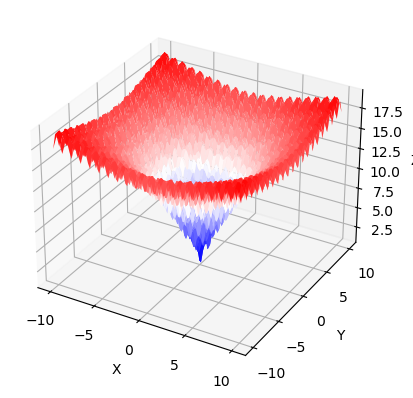

In [23]:
surface_plot(f, (-10, 10), (-10, 10), x_label='X', y_label='Y', z_label='Z')

In [24]:
kwargs = {
    'noise': 'anisotropic',
    'sigma': 5,
}

M = kwargs.get('M', 1)
resampling =  rsmp.resampling([rsmp.loss_update_resampling(M=M, wait_thresh=40)], M)
post_process = CompositePostProcess([
    DefaultPostProcess(),
    ReshuffleAgentBatches(),
    lambda dyn: resampling(dyn)
])

d = 2
dyn = CBO(
    f,
    d=d,
    track_args={"names": ["x", "consensus"]},
    verbosity=1,
    post_process=post_process,
    **kwargs
)
result = dyn.optimize()

....................
Starting Optimization with dynamic: CBO
....................
Time: 0.010, best current energy: [1.06004401]
Number of function evaluations: [40]
Time: 0.020, best current energy: [0.63649078]
Number of function evaluations: [60]
Time: 0.030, best current energy: [0.80058137]
Number of function evaluations: [80]
Time: 0.040, best current energy: [0.60833486]
Number of function evaluations: [100]
Time: 0.050, best current energy: [0.45612832]
Number of function evaluations: [120]
Time: 0.060, best current energy: [0.69655567]
Number of function evaluations: [140]
Time: 0.070, best current energy: [0.51393274]
Number of function evaluations: [160]
Time: 0.080, best current energy: [0.76381102]
Number of function evaluations: [180]
Time: 0.090, best current energy: [0.52308852]
Number of function evaluations: [200]
Time: 0.100, best current energy: [0.30074349]
Number of function evaluations: [220]
Time: 0.110, best current energy: [0.32341511]
Number of function evalu

Time: 1.810, best current energy: [0.0010696]
Number of function evaluations: [3640]
Time: 1.820, best current energy: [0.00101578]
Number of function evaluations: [3660]
Time: 1.830, best current energy: [0.00095657]
Number of function evaluations: [3680]
Time: 1.840, best current energy: [0.00094267]
Number of function evaluations: [3700]
Time: 1.850, best current energy: [0.00086091]
Number of function evaluations: [3720]
Time: 1.860, best current energy: [0.00069623]
Number of function evaluations: [3740]
Time: 1.870, best current energy: [0.00073855]
Number of function evaluations: [3760]
Time: 1.880, best current energy: [0.00084205]
Number of function evaluations: [3780]
Time: 1.890, best current energy: [0.00082863]
Number of function evaluations: [3800]
Time: 1.900, best current energy: [0.00063825]
Number of function evaluations: [3820]
Time: 1.910, best current energy: [0.00066383]
Number of function evaluations: [3840]
Time: 1.920, best current energy: [0.00066186]
Number o

Time: 3.870, best current energy: [0.00197653]
Number of function evaluations: [7760]
Time: 3.880, best current energy: [0.00197653]
Number of function evaluations: [7780]
Time: 3.890, best current energy: [0.00197653]
Number of function evaluations: [7800]
Time: 3.900, best current energy: [0.00197653]
Number of function evaluations: [7820]
Time: 3.910, best current energy: [0.00197653]
Number of function evaluations: [7840]
Time: 3.920, best current energy: [0.00197653]
Number of function evaluations: [7860]
Time: 3.930, best current energy: [0.00197653]
Number of function evaluations: [7880]
Time: 3.940, best current energy: [0.00197653]
Number of function evaluations: [7900]
Time: 3.950, best current energy: [0.00197653]
Number of function evaluations: [7920]
Time: 3.960, best current energy: [0.00192417]
Number of function evaluations: [7940]
Time: 3.970, best current energy: [0.00192468]
Number of function evaluations: [7960]
Resampled in runs [0]
Time: 3.980, best current energy

Time: 6.000, best current energy: [1.63126016]
Number of function evaluations: [12020]
Time: 6.010, best current energy: [0.56135015]
Number of function evaluations: [12040]
Time: 6.020, best current energy: [0.45642747]
Number of function evaluations: [12060]
Time: 6.030, best current energy: [0.45642747]
Number of function evaluations: [12080]
Time: 6.040, best current energy: [0.33789613]
Number of function evaluations: [12100]
Time: 6.050, best current energy: [0.14331896]
Number of function evaluations: [12120]
Time: 6.060, best current energy: [0.14331896]
Number of function evaluations: [12140]
Time: 6.070, best current energy: [0.05993015]
Number of function evaluations: [12160]
Time: 6.080, best current energy: [0.05716707]
Number of function evaluations: [12180]
Time: 6.090, best current energy: [0.01899527]
Number of function evaluations: [12200]
Time: 6.100, best current energy: [0.01899527]
Number of function evaluations: [12220]
Time: 6.110, best current energy: [0.018995

Time: 8.150, best current energy: [0.01611021]
Number of function evaluations: [16320]
Time: 8.160, best current energy: [0.01611021]
Number of function evaluations: [16340]
Time: 8.170, best current energy: [0.01611021]
Number of function evaluations: [16360]
Time: 8.180, best current energy: [0.01611021]
Number of function evaluations: [16380]
Time: 8.190, best current energy: [0.01368451]
Number of function evaluations: [16400]
Time: 8.200, best current energy: [0.01368451]
Number of function evaluations: [16420]
Time: 8.210, best current energy: [0.01368451]
Number of function evaluations: [16440]
Time: 8.220, best current energy: [0.01172904]
Number of function evaluations: [16460]
Time: 8.230, best current energy: [0.0095074]
Number of function evaluations: [16480]
Time: 8.240, best current energy: [0.0095074]
Number of function evaluations: [16500]
Time: 8.250, best current energy: [0.00950733]
Number of function evaluations: [16520]
Time: 8.260, best current energy: [0.00950733

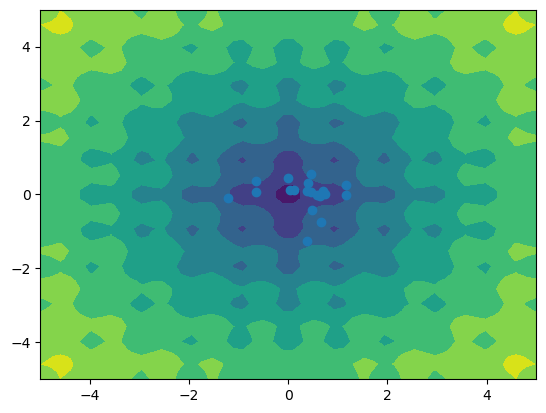

In [25]:
plotter = plotting.plot_dynamic_history(dyn, objective_args={"x_min": -5, "x_max": 5})

In [26]:
target = torch.zeros((1, d))
mse_loss(torch.tensor(result), target)

tensor(1.4186e-13, dtype=torch.float64)

In [27]:
f(result)

tensor([1.4241e-06], dtype=torch.float64)

### Compare to SGD

In [28]:
x = torch.normal(0, 1, size=(1, d))

best_x, history_params, history_values, = gradient_descent(ackley, x)
mse_loss(best_x, target)

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_46879/673266039.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(init, requires_grad=True)


tensor(3.8985)

In [29]:
f(best_x)

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_46879/3191892244.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  f = lambda x: ackley(torch.tensor(x[None, :]))[-1]


tensor([6.5596])

### Schwefel Function
$f(x) = 418.9829d - \sum_{i=1}^d{x_i\sin(\sqrt{|x_i|})}$

In [30]:
def schwefel(x: torch.tensor) -> float:
    x = torch.clip(x, -500., 500.)
    d = x.shape[-1]
    
    result = 418.9829 * d - torch.sum(x * torch.sin(torch.sqrt(torch.abs(x))), dim=-1)
    result[torch.abs(x).max() > 1000] = 1e8
    
    return result

In [31]:
f = lambda x: schwefel(torch.tensor(x[None, :]))[-1]

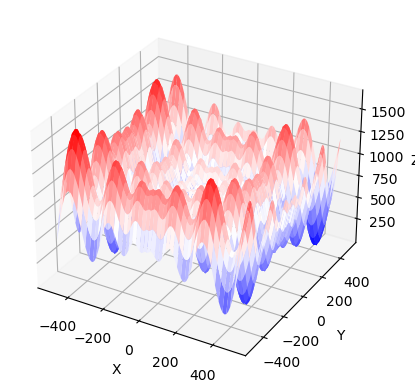

In [32]:
surface_plot(f, (-500, 500), (-500, 500), x_label='X', y_label='Y', z_label='Z')

In [33]:
kwargs = {
    'noise': 'anisotropic',
    'sigma': 5,
}

M = kwargs.get('M', 1)
resampling =  rsmp.resampling([rsmp.loss_update_resampling(M=M, wait_thresh=40)], M)
post_process = CompositePostProcess([
    DefaultPostProcess(),
    ReshuffleAgentBatches(),
    lambda dyn: resampling(dyn)
])

d = 2
dyn = CBO(
    f,
    d=d,
    track_args={"names": ["x", "consensus"]},
    verbosity=1,
    post_process=post_process,
    **kwargs
)
result = dyn.optimize()

....................
Starting Optimization with dynamic: CBO
....................
Time: 0.010, best current energy: [837.23546422]
Number of function evaluations: [40]
Time: 0.020, best current energy: [836.86945957]
Number of function evaluations: [60]
Time: 0.030, best current energy: [836.80344006]
Number of function evaluations: [80]
Time: 0.040, best current energy: [836.61845484]
Number of function evaluations: [100]
Time: 0.050, best current energy: [836.82103816]
Number of function evaluations: [120]
Time: 0.060, best current energy: [835.68547947]
Number of function evaluations: [140]
Time: 0.070, best current energy: [835.78039857]
Number of function evaluations: [160]
Time: 0.080, best current energy: [835.48138972]
Number of function evaluations: [180]
Time: 0.090, best current energy: [835.50070362]
Number of function evaluations: [200]
Time: 0.100, best current energy: [834.95526126]
Number of function evaluations: [220]
Time: 0.110, best current energy: [834.72892537]
Nu

Time: 1.950, best current energy: [6.81842332e-05]
Number of function evaluations: [3920]
Time: 1.960, best current energy: [6.94645877e-05]
Number of function evaluations: [3940]
Time: 1.970, best current energy: [7.21883828e-05]
Number of function evaluations: [3960]
Time: 1.980, best current energy: [7.01858123e-05]
Number of function evaluations: [3980]
Time: 1.990, best current energy: [7.09273979e-05]
Number of function evaluations: [4000]
Time: 2.000, best current energy: [7.32175232e-05]
Number of function evaluations: [4020]
Time: 2.010, best current energy: [8.2552991e-05]
Number of function evaluations: [4040]
Time: 2.020, best current energy: [8.42744114e-05]
Number of function evaluations: [4060]
Time: 2.030, best current energy: [8.99510043e-05]
Number of function evaluations: [4080]
Time: 2.040, best current energy: [8.37049015e-05]
Number of function evaluations: [4100]
Time: 2.050, best current energy: [8.21548598e-05]
Number of function evaluations: [4120]
Time: 2.060

Time: 4.680, best current energy: [0.00156684]
Number of function evaluations: [9380]
Time: 4.690, best current energy: [0.00156684]
Number of function evaluations: [9400]
Time: 4.700, best current energy: [0.0001242]
Number of function evaluations: [9420]
Time: 4.710, best current energy: [0.0001242]
Number of function evaluations: [9440]
Time: 4.720, best current energy: [0.0001242]
Number of function evaluations: [9460]
Time: 4.730, best current energy: [0.0001242]
Number of function evaluations: [9480]
Time: 4.740, best current energy: [0.0001242]
Number of function evaluations: [9500]
Time: 4.750, best current energy: [0.0001242]
Number of function evaluations: [9520]
Time: 4.760, best current energy: [0.0001242]
Number of function evaluations: [9540]
Time: 4.770, best current energy: [2.65068493e-05]
Number of function evaluations: [9560]
Time: 4.780, best current energy: [2.65070241e-05]
Number of function evaluations: [9580]
Time: 4.790, best current energy: [2.64914152e-05]
Nu

Time: 7.490, best current energy: [0.00020425]
Number of function evaluations: [15000]
Time: 7.500, best current energy: [0.00020425]
Number of function evaluations: [15020]
Time: 7.510, best current energy: [0.00012448]
Number of function evaluations: [15040]
Time: 7.520, best current energy: [4.23703759e-05]
Number of function evaluations: [15060]
Time: 7.530, best current energy: [4.2371352e-05]
Number of function evaluations: [15080]
Time: 7.540, best current energy: [4.1717288e-05]
Number of function evaluations: [15100]
Time: 7.550, best current energy: [4.07807802e-05]
Number of function evaluations: [15120]
Time: 7.560, best current energy: [4.04469931e-05]
Number of function evaluations: [15140]
Time: 7.570, best current energy: [3.96795726e-05]
Number of function evaluations: [15160]
Time: 7.580, best current energy: [4.0443914e-05]
Number of function evaluations: [15180]
Time: 7.590, best current energy: [4.15728026e-05]
Number of function evaluations: [15200]
Time: 7.600, b

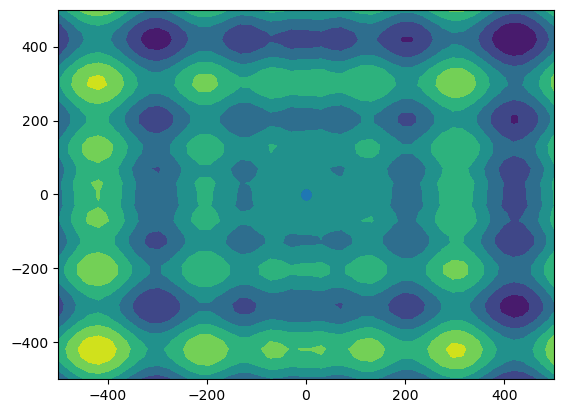

In [34]:
plotter = plotting.plot_dynamic_history(dyn, objective_args={"x_min": -500, "x_max": 500})

In [35]:
target = 420.9687 * torch.ones((1, d))
mse_loss(torch.tensor(result), target)

tensor(5.9644e-09, dtype=torch.float64)

In [36]:
f(result).min()

tensor(2.5455e-05, dtype=torch.float64)

### Compare to SGD

In [37]:
x = torch.normal(0, 1, size=(1, d))

best_x, history_params, history_values, = gradient_descent(schwefel, x)
mse_loss(best_x, target)

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_46879/673266039.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(init, requires_grad=True)


tensor(173023.8438)

In [38]:
f(best_x)

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_46879/1399477423.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  f = lambda x: schwefel(torch.tensor(x[None, :]))[-1]


tensor([830.0974])

### Levy Function
$f(x) = \sin^2(\pi w_1) + \sum_{i=1}^{d-1}{(w_i-1)^2[1 + 10\sin^2(\pi w_i + 1)] + (w_d-1)^2[1 + \sin^2(2*\pi w_d)]}, $
$w_i = 1 + \frac{x_i-1}{4}$

In [39]:
def levy(x: torch.tensor) -> float:
    d = x.shape[-1]
    
    w = 1 + (x - 1) / 4
    result = torch.sin(torch.pi * w[..., 0])**2
    
    if d > 2:
        w_prime = w[..., :-2]
        result += torch.sum((w_prime - 1)**2 * (1 + 10 * torch.sin(torch.pi * w_prime + 1)**2), dim=-1)
        
    result += (w[..., -1] - 1)**2 * (1 + torch.sin(2 * torch.pi * w[..., -1])**2)
    
    return result

In [40]:
f = lambda x: levy(torch.tensor(x[None, :]))[-1]

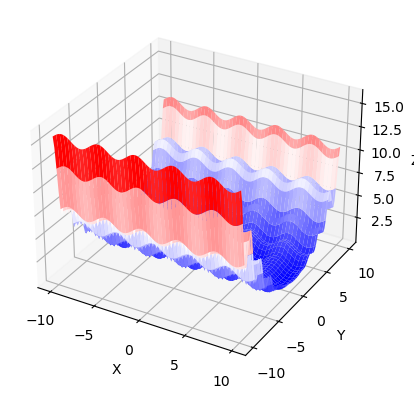

In [41]:
surface_plot(f, (-10, 10), (-10, 10), x_label='X', y_label='Y', z_label='Z')

In [42]:
# Hyperparameters
kwargs = {
    'noise': 'anisotropic',
    'sigma': 5
}

M = kwargs.get('M', 1)
resampling =  rsmp.resampling([rsmp.loss_update_resampling(M=M, wait_thresh=40)], M)
post_process = CompositePostProcess([
    DefaultPostProcess(),
    ReshuffleAgentBatches(),
    lambda dyn: resampling(dyn)
])

d = 2
dyn = CBO(
    f,
    d=d,
    track_args={"names": ["x", "consensus"]},
    verbosity=1,
    post_process=post_process,
    **kwargs
)
result = dyn.optimize()

....................
Starting Optimization with dynamic: CBO
....................
Time: 0.010, best current energy: [0.10386642]
Number of function evaluations: [40]
Time: 0.020, best current energy: [0.07658702]
Number of function evaluations: [60]
Time: 0.030, best current energy: [0.13623332]
Number of function evaluations: [80]
Time: 0.040, best current energy: [0.11562412]
Number of function evaluations: [100]
Time: 0.050, best current energy: [0.10597401]
Number of function evaluations: [120]
Time: 0.060, best current energy: [0.23035285]
Number of function evaluations: [140]
Time: 0.070, best current energy: [0.25212804]
Number of function evaluations: [160]
Time: 0.080, best current energy: [0.27662831]
Number of function evaluations: [180]
Time: 0.090, best current energy: [0.15822251]
Number of function evaluations: [200]
Time: 0.100, best current energy: [0.13634898]
Number of function evaluations: [220]
Time: 0.110, best current energy: [0.08874688]
Number of function evalu

Time: 1.650, best current energy: [0.08195228]
Number of function evaluations: [3320]
Time: 1.660, best current energy: [0.03466081]
Number of function evaluations: [3340]
Time: 1.670, best current energy: [0.03466081]
Number of function evaluations: [3360]
Time: 1.680, best current energy: [0.00364926]
Number of function evaluations: [3380]
Time: 1.690, best current energy: [0.00048551]
Number of function evaluations: [3400]
Time: 1.700, best current energy: [0.00036413]
Number of function evaluations: [3420]
Time: 1.710, best current energy: [0.00036413]
Number of function evaluations: [3440]
Time: 1.720, best current energy: [0.00037411]
Number of function evaluations: [3460]
Time: 1.730, best current energy: [0.00037536]
Number of function evaluations: [3480]
Time: 1.740, best current energy: [0.00037536]
Number of function evaluations: [3500]
Time: 1.750, best current energy: [0.0003754]
Number of function evaluations: [3520]
Time: 1.760, best current energy: [0.0003754]
Number of

Time: 3.760, best current energy: [0.00011714]
Number of function evaluations: [7540]
Time: 3.770, best current energy: [0.00011714]
Number of function evaluations: [7560]
Time: 3.780, best current energy: [0.00011714]
Number of function evaluations: [7580]
Time: 3.790, best current energy: [0.00011714]
Number of function evaluations: [7600]
Time: 3.800, best current energy: [0.00011714]
Number of function evaluations: [7620]
Time: 3.810, best current energy: [0.00011763]
Number of function evaluations: [7640]
Time: 3.820, best current energy: [0.00011763]
Number of function evaluations: [7660]
Time: 3.830, best current energy: [5.91831575e-05]
Number of function evaluations: [7680]
Time: 3.840, best current energy: [4.21441452e-05]
Number of function evaluations: [7700]
Time: 3.850, best current energy: [4.21441452e-05]
Number of function evaluations: [7720]
Time: 3.860, best current energy: [4.21441452e-05]
Number of function evaluations: [7740]
Time: 3.870, best current energy: [4.2

Time: 5.870, best current energy: [8.53462464e-05]
Number of function evaluations: [11760]
Time: 5.880, best current energy: [8.53462464e-05]
Number of function evaluations: [11780]
Resampled in runs [0]
Time: 5.890, best current energy: [8.53462464e-05]
Number of function evaluations: [11800]
Time: 5.900, best current energy: [0.00717144]
Number of function evaluations: [11820]
Time: 5.910, best current energy: [0.00066942]
Number of function evaluations: [11840]
Time: 5.920, best current energy: [0.00066942]
Number of function evaluations: [11860]
Time: 5.930, best current energy: [0.00066942]
Number of function evaluations: [11880]
Time: 5.940, best current energy: [0.00066942]
Number of function evaluations: [11900]
Time: 5.950, best current energy: [0.00066942]
Number of function evaluations: [11920]
Time: 5.960, best current energy: [0.00066942]
Number of function evaluations: [11940]
Time: 5.970, best current energy: [0.00050875]
Number of function evaluations: [11960]
Time: 5.9

Time: 8.020, best current energy: [0.00082652]
Number of function evaluations: [16060]
Time: 8.030, best current energy: [0.00082652]
Number of function evaluations: [16080]
Time: 8.040, best current energy: [0.00082652]
Number of function evaluations: [16100]
Time: 8.050, best current energy: [0.00082652]
Number of function evaluations: [16120]
Time: 8.060, best current energy: [0.00082652]
Number of function evaluations: [16140]
Time: 8.070, best current energy: [0.00082652]
Number of function evaluations: [16160]
Time: 8.080, best current energy: [0.00082652]
Number of function evaluations: [16180]
Time: 8.090, best current energy: [0.00068082]
Number of function evaluations: [16200]
Time: 8.100, best current energy: [0.00488659]
Number of function evaluations: [16220]
Time: 8.110, best current energy: [0.00488659]
Number of function evaluations: [16240]
Time: 8.120, best current energy: [0.00488659]
Number of function evaluations: [16260]
Time: 8.130, best current energy: [0.004658

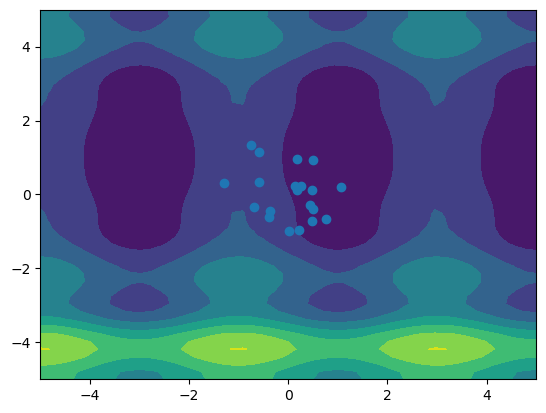

In [43]:
plotter = plotting.plot_dynamic_history(dyn, objective_args={"x_min": -5, "x_max":5})

In [44]:
target = torch.ones((1, d))
mse_loss(torch.tensor(result), target)

tensor(12799.9094, dtype=torch.float64)

In [45]:
f(result)

tensor([8.1112e-07], dtype=torch.float64)

### Compare to SGD

In [46]:
x = torch.normal(0, 1, size=(1, d))

best_x, history_params, history_values, = gradient_descent(levy, x)
mse_loss(best_x, target)

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_46879/673266039.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(init, requires_grad=True)


tensor(3.3377e-06)

In [47]:
f(best_x)

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_46879/603640452.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  f = lambda x: levy(torch.tensor(x[None, :]))[-1]


tensor([4.1724e-07])